In [1]:
import sys
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
import joblib
from joblib import dump

We have several files, each containing part of the data. Let's create dataframes for each.

In [2]:
df_campaign_desc=pd.read_csv('./data/campaign_desc.csv')
df_campaign_table=pd.read_csv('./data/campaign_table.csv')
df_causal_data=pd.read_csv('./data/causal_data.csv')
df_coupon_redempt=pd.read_csv('./data/coupon_redempt.csv')
df_coupon=pd.read_csv('./data/coupon.csv')
df_hh_demographic=pd.read_csv('./data/hh_demographic.csv')
df_product=pd.read_csv('./data/product.csv')
df_transaction_data=pd.read_csv('./data/transaction_data.csv')

We'll look through each dataframe and then combine them based on common columns. 

In [3]:
df_campaign_desc.head(3)

,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY
0,TypeB,24,659,719
1,TypeC,15,547,708
2,TypeB,25,659,691


In [4]:
np.sort(df_campaign_desc["CAMPAIGN"].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [5]:
df_campaign_table.head(3)

,DESCRIPTION,household_key,CAMPAIGN
0,TypeA,17,26
1,TypeA,27,26
2,TypeA,212,26


In [6]:
np.sort(df_campaign_table["CAMPAIGN"].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [7]:
df_coupon_redempt.head(3)

,household_key,DAY,COUPON_UPC,CAMPAIGN
0,1,421,10000085364,8
1,1,421,51700010076,8
2,1,427,54200000033,8


In [8]:
np.sort(df_coupon_redempt["CAMPAIGN"].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [9]:
df_merged=pd.merge(df_campaign_table,df_campaign_desc,how="inner",on="CAMPAIGN")

In [10]:
df_merged.drop('DESCRIPTION_y', axis=1, inplace=True)
df_merged.rename(columns={'DESCRIPTION_x':'description'},inplace=True)
df_merged

,description,household_key,CAMPAIGN,START_DAY,END_DAY
0,TypeA,17,26,224,264
1,TypeA,27,26,224,264
2,TypeA,212,26,224,264
3,TypeA,208,26,224,264
4,TypeA,192,26,224,264
...,...,...,...,...,...
7203,TypeC,1803,15,547,708
7204,TypeC,1082,15,547,708
7205,TypeC,942,15,547,708
7206,TypeC,855,15,547,708


In [11]:
df_merged=pd.merge(df_merged,df_coupon_redempt,how='inner',on=['household_key','CAMPAIGN'])
df_merged

,description,household_key,CAMPAIGN,START_DAY,END_DAY,DAY,COUPON_UPC
0,TypeA,2443,26,224,264,228,57457010076
1,TypeA,2305,26,224,264,237,57143030076
2,TypeA,2305,26,224,264,237,57756765876
3,TypeA,2305,26,224,264,260,54900020032
4,TypeA,2280,26,224,264,225,57008510075
...,...,...,...,...,...,...,...
2313,TypeC,256,20,615,685,638,54589399275
2314,TypeC,19,20,615,685,684,54100027032
2315,TypeC,1917,6,393,425,396,53663271277
2316,TypeC,1017,15,547,708,575,55000035213


In [12]:
df_merged['COUPON_UPC'].isna().sum()

0

Now let's combined this merged table with household demographics table. But let's take a look at the table first.

In [13]:
df_hh_demographic.head(3)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8


In [14]:
len(df_hh_demographic['household_key'].unique())

801

Which mean there are 801 unique households in this data set.

In [15]:
df_merged=pd.merge(df_merged, df_hh_demographic, how='inner', on='household_key')

In [16]:
df_merged

,description,household_key,CAMPAIGN,START_DAY,END_DAY,DAY,COUPON_UPC,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
0,TypeA,2305,26,224,264,237,57143030076,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown
1,TypeA,2305,26,224,264,237,57756765876,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown
2,TypeA,2305,26,224,264,260,54900020032,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown
3,TypeA,2305,30,323,369,348,53010030033,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown
4,TypeA,2305,13,504,551,510,10000085426,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1851,TypeC,560,14,531,596,554,51111124078,19-24,U,35-49K,Unknown,2 Adults No Kids,2,None/Unknown
1852,TypeC,560,14,531,596,585,53620010028,19-24,U,35-49K,Unknown,2 Adults No Kids,2,None/Unknown
1853,TypeC,560,14,531,596,585,54800140060,19-24,U,35-49K,Unknown,2 Adults No Kids,2,None/Unknown
1854,TypeC,19,20,615,685,684,54100027032,35-44,B,15-24K,Unknown,Single Female,1,None/Unknown


At this point it'd be interesting to see how many households recieved each campaign:

In [17]:
df_merged['CAMPAIGN'].value_counts()

18    543
13    510
8     276
26     61
23     54
25     51
30     48
22     46
16     38
9      33
17     30
14     27
20     27
19     20
12     19
10     14
29     12
24      9
11      7
4       7
5       7
2       5
7       4
3       2
21      2
28      1
6       1
27      1
15      1
Name: CAMPAIGN, dtype: int64

The data across campaigns is very imbalanced. While we have data on 543 households receiving campaign 18, there are four campaigns that have data from only 1 household. Next, we focus on joining df_coupons to the merged table. This will give us Product ID, which is necessary to combine data from the remaining tables.

In [18]:
df_coupon[["COUPON_UPC","CAMPAIGN"]].value_counts()

COUPON_UPC   CAMPAIGN
10000085478  18          14477
10000085428  13          14367
10000085427  13           5717
10000085477  18           5686
10000085479  18           5474
                         ...  
10000089010  8               1
54650032278  30              1
10000089016  8               1
54589353178  3               1
57171010032  30              1
Length: 1397, dtype: int64

In [19]:
df_merged=pd.merge(df_merged,df_coupon,how='left',on=['CAMPAIGN','COUPON_UPC'])

In [20]:
df_merged

,description,household_key,CAMPAIGN,START_DAY,END_DAY,DAY,COUPON_UPC,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,PRODUCT_ID
0,TypeA,2305,26,224,264,237,57143030076,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,938300
1,TypeA,2305,26,224,264,237,57143030076,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,1699081
2,TypeA,2305,26,224,264,237,57143030076,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,1805288
3,TypeA,2305,26,224,264,237,57143030076,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,100282
4,TypeA,2305,26,224,264,237,57143030076,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,859427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1785434,TypeC,1820,15,547,708,555,55000035576,45-54,A,150-174K,Homeowner,2 Adults No Kids,2,None/Unknown,15715968
1785435,TypeC,1820,15,547,708,555,55000035576,45-54,A,150-174K,Homeowner,2 Adults No Kids,2,None/Unknown,15715969
1785436,TypeC,1820,15,547,708,555,55000035576,45-54,A,150-174K,Homeowner,2 Adults No Kids,2,None/Unknown,15716072
1785437,TypeC,1820,15,547,708,555,55000035576,45-54,A,150-174K,Homeowner,2 Adults No Kids,2,None/Unknown,15716098


In [21]:
df_product

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ
...,...,...,...,...,...,...,...
92348,18293142,6384,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,
92349,18293439,6393,DRUG GM,National,BOOKSTORE,CHILDRENS LOW END,
92350,18293696,6406,DRUG GM,National,BOOKSTORE,PAPERBACK BEST SELLER,
92351,18294080,6442,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,


In [22]:
df_merged=pd.merge(df_merged,df_product,how='inner',on='PRODUCT_ID')

In [23]:
df_merged

,description,household_key,CAMPAIGN,START_DAY,END_DAY,DAY,COUPON_UPC,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,...,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,TypeA,2305,26,224,264,237,57143030076,45-54,B,50-74K,...,Single Female,1,None/Unknown,938300,1646,PRODUCE,National,SALAD MIX,BLENDS,10 OZ
1,TypeA,2305,18,587,642,599,10000085475,45-54,B,50-74K,...,Single Female,1,None/Unknown,938300,1646,PRODUCE,National,SALAD MIX,BLENDS,10 OZ
2,TypeA,979,13,504,551,506,10000085425,35-44,B,35-49K,...,1 Adult Kids,2,1,938300,1646,PRODUCE,National,SALAD MIX,BLENDS,10 OZ
3,TypeA,979,18,587,642,606,57143020076,35-44,B,35-49K,...,1 Adult Kids,2,1,938300,1646,PRODUCE,National,SALAD MIX,BLENDS,10 OZ
4,TypeA,889,18,587,642,600,10000085475,25-34,A,50-74K,...,2 Adults Kids,4,2,938300,1646,PRODUCE,National,SALAD MIX,BLENDS,10 OZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1785434,TypeB,1802,21,624,656,654,57027722976,45-54,U,150-174K,...,2 Adults No Kids,2,None/Unknown,14110967,1459,DELI,National,CHEESES,CHEESE:SPECIALTY PREPACK,5 OZ
1785435,TypeB,1367,23,646,684,656,55420811176,35-44,U,75-99K,...,2 Adults Kids,3,1,8118584,6251,GROCERY,National,SHORTENING/OIL,COOKING OIL: PEANUT SAFFLOWER,20 OZ
1785436,TypeB,1367,23,646,684,656,55420811176,35-44,U,75-99K,...,2 Adults Kids,3,1,8124141,6251,GROCERY,National,SHORTENING/OIL,COOKING OIL: PEANUT SAFFLOWER,20 OZ
1785437,TypeB,1804,25,659,691,668,52100000076,65+,A,35-49K,...,2 Adults No Kids,2,None/Unknown,1126918,1075,GROCERY,National,CRACKERS/MISC BKD FD,BUTTER SPRAY CRACKER (RITZ/CLU,16 OZ


In [24]:
#df_merged=pd.merge(df_merged,df_causal_data,how='inner',on='PRODUCT_ID')

In [25]:
#df_merged=pd.merge(df_merged,df_transaction_data,how='inner',on='PRODUCT_ID')

In [26]:
df_merged.columns

Index(['description', 'household_key', 'CAMPAIGN', 'START_DAY', 'END_DAY',
       'DAY', 'COUPON_UPC', 'AGE_DESC', 'MARITAL_STATUS_CODE', 'INCOME_DESC',
       'HOMEOWNER_DESC', 'HH_COMP_DESC', 'HOUSEHOLD_SIZE_DESC',
       'KID_CATEGORY_DESC', 'PRODUCT_ID', 'MANUFACTURER', 'DEPARTMENT',
       'BRAND', 'COMMODITY_DESC', 'SUB_COMMODITY_DESC',
       'CURR_SIZE_OF_PRODUCT'],
      dtype='object')

In [27]:
sys.getsizeof(df_merged)/1000000  #df_merged is a large dataframe. This is to be aware of how much space it is occupying in the memory.

1627.951711

In [28]:
df_transaction_data.columns

Index(['household_key', 'BASKET_ID', 'DAY', 'PRODUCT_ID', 'QUANTITY',
       'SALES_VALUE', 'STORE_ID', 'RETAIL_DISC', 'TRANS_TIME', 'WEEK_NO',
       'COUPON_DISC', 'COUPON_MATCH_DISC'],
      dtype='object')

In [29]:
df_transaction_data.drop(['DAY','BASKET_ID', 'WEEK_NO'], axis=1, inplace=True)      #removing some of the unnecessary columns.

Finally, let's merge df_merge to transaction data and save it as a csv.

In [30]:
df_merged=pd.merge(df_transaction_data,df_merged,how='inner',on=['household_key','PRODUCT_ID'])

In [31]:
df_merged

,household_key,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,COUPON_DISC,COUPON_MATCH_DISC,description,...,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,2305,873203,1,1.67,414,-1.02,1300,0.0,0.0,TypeA,...,Homeowner,Single Female,1,None/Unknown,69,GROCERY,Private,CHEESE,SHREDDED CHEESE,8 OZ
1,2305,873203,1,1.79,414,-0.90,1220,0.0,0.0,TypeA,...,Homeowner,Single Female,1,None/Unknown,69,GROCERY,Private,CHEESE,SHREDDED CHEESE,8 OZ
2,2305,873203,1,1.89,414,0.00,1111,0.0,0.0,TypeA,...,Homeowner,Single Female,1,None/Unknown,69,GROCERY,Private,CHEESE,SHREDDED CHEESE,8 OZ
3,2305,873203,1,1.67,414,-0.22,1341,0.0,0.0,TypeA,...,Homeowner,Single Female,1,None/Unknown,69,GROCERY,Private,CHEESE,SHREDDED CHEESE,8 OZ
4,2305,873203,1,1.67,414,-0.22,1243,0.0,0.0,TypeA,...,Homeowner,Single Female,1,None/Unknown,69,GROCERY,Private,CHEESE,SHREDDED CHEESE,8 OZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112017,1146,9858843,1,2.50,304,-0.19,1456,0.0,0.0,TypeA,...,Homeowner,1 Adult Kids,4,3+,135,GROCERY,National,FRZN POTATOES,FRZN FRENCH FRIES,26 OZ
112018,1823,1130763,2,3.70,402,0.00,1334,0.0,0.0,TypeA,...,Homeowner,2 Adults No Kids,2,None/Unknown,1251,GROCERY,National,SOUP,RTS SOUP: CHUNKY/HOMESTYLE ET,18.8 OZ
112019,1823,9885380,1,5.49,402,0.00,1334,0.0,0.0,TypeA,...,Homeowner,2 Adults No Kids,2,None/Unknown,26,DRUG GM,National,DIETARY AID PRODUCTS,DIET CNTRL LIQS NUTRITIONAL,
112020,1823,15927110,1,5.59,402,0.00,1334,0.0,0.0,TypeA,...,Homeowner,2 Adults No Kids,2,None/Unknown,26,DRUG GM,National,DIETARY AID PRODUCTS,DIET CNTRL LIQS NUTRITIONAL,


In [32]:
df_merged.to_csv('./data/all_tables_combined.csv',index=0)

In [33]:
df_merged

,household_key,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,COUPON_DISC,COUPON_MATCH_DISC,description,...,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,2305,873203,1,1.67,414,-1.02,1300,0.0,0.0,TypeA,...,Homeowner,Single Female,1,None/Unknown,69,GROCERY,Private,CHEESE,SHREDDED CHEESE,8 OZ
1,2305,873203,1,1.79,414,-0.90,1220,0.0,0.0,TypeA,...,Homeowner,Single Female,1,None/Unknown,69,GROCERY,Private,CHEESE,SHREDDED CHEESE,8 OZ
2,2305,873203,1,1.89,414,0.00,1111,0.0,0.0,TypeA,...,Homeowner,Single Female,1,None/Unknown,69,GROCERY,Private,CHEESE,SHREDDED CHEESE,8 OZ
3,2305,873203,1,1.67,414,-0.22,1341,0.0,0.0,TypeA,...,Homeowner,Single Female,1,None/Unknown,69,GROCERY,Private,CHEESE,SHREDDED CHEESE,8 OZ
4,2305,873203,1,1.67,414,-0.22,1243,0.0,0.0,TypeA,...,Homeowner,Single Female,1,None/Unknown,69,GROCERY,Private,CHEESE,SHREDDED CHEESE,8 OZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112017,1146,9858843,1,2.50,304,-0.19,1456,0.0,0.0,TypeA,...,Homeowner,1 Adult Kids,4,3+,135,GROCERY,National,FRZN POTATOES,FRZN FRENCH FRIES,26 OZ
112018,1823,1130763,2,3.70,402,0.00,1334,0.0,0.0,TypeA,...,Homeowner,2 Adults No Kids,2,None/Unknown,1251,GROCERY,National,SOUP,RTS SOUP: CHUNKY/HOMESTYLE ET,18.8 OZ
112019,1823,9885380,1,5.49,402,0.00,1334,0.0,0.0,TypeA,...,Homeowner,2 Adults No Kids,2,None/Unknown,26,DRUG GM,National,DIETARY AID PRODUCTS,DIET CNTRL LIQS NUTRITIONAL,
112020,1823,15927110,1,5.59,402,0.00,1334,0.0,0.0,TypeA,...,Homeowner,2 Adults No Kids,2,None/Unknown,26,DRUG GM,National,DIETARY AID PRODUCTS,DIET CNTRL LIQS NUTRITIONAL,


In [34]:
df_merged['retail_disc/sales_value']=df_merged['RETAIL_DISC']/df_merged['SALES_VALUE']
df_merged['coupon_disc/sales_value']=df_merged['COUPON_DISC']/df_merged['SALES_VALUE']

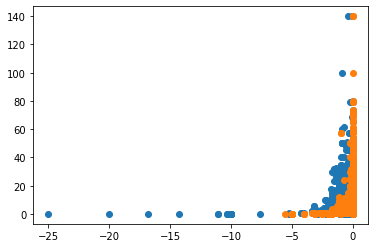

In [35]:
df_merged.sort_values(by='retail_disc/sales_value')
plt.scatter(x=df_merged['retail_disc/sales_value'],y=df_merged['SALES_VALUE'])
df_merged.sort_values(by='coupon_disc/sales_value')
plt.scatter(x=df_merged['coupon_disc/sales_value'],y=df_merged['SALES_VALUE'])

Let's free up some space by deleting df_merge and trigger garbage collection. We'll load the saved csv file. It has all the necessary data.

In [36]:
del df_merged
gc.collect()

22

In [37]:
df_data=pd.read_csv("./data/all_tables_combined.csv")   #read data from all_tables_combined.csv

In [38]:
df_data.head(3)

,household_key,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,COUPON_DISC,COUPON_MATCH_DISC,description,...,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,2305,873203,1,1.67,414,-1.02,1300,0.0,0.0,TypeA,...,Homeowner,Single Female,1,None/Unknown,69,GROCERY,Private,CHEESE,SHREDDED CHEESE,8 OZ
1,2305,873203,1,1.79,414,-0.90,1220,0.0,0.0,TypeA,...,Homeowner,Single Female,1,None/Unknown,69,GROCERY,Private,CHEESE,SHREDDED CHEESE,8 OZ
2,2305,873203,1,1.89,414,0.00,1111,0.0,0.0,TypeA,...,Homeowner,Single Female,1,None/Unknown,69,GROCERY,Private,CHEESE,SHREDDED CHEESE,8 OZ


In [39]:
#df_s_parent=df_data[df_data['HH_COMP_DESC']=="1 Adult Kids"]
#df_s_parent=df_data

In [40]:
#determining length of campaign and dropping unnecessary columns.

df_data['NUM_DAYS']=df_data['END_DAY'] - df_data['START_DAY'] + 1
df_data.drop(['START_DAY','END_DAY','COUPON_UPC','household_key','PRODUCT_ID'], axis=1, inplace=True)

In [41]:
df_data.head(2)

,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,COUPON_DISC,COUPON_MATCH_DISC,description,CAMPAIGN,DAY,...,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,NUM_DAYS
0,1,1.67,414,-1.02,1300,0.0,0.0,TypeA,13,510,...,Single Female,1,None/Unknown,69,GROCERY,Private,CHEESE,SHREDDED CHEESE,8 OZ,48
1,1,1.79,414,-0.90,1220,0.0,0.0,TypeA,13,510,...,Single Female,1,None/Unknown,69,GROCERY,Private,CHEESE,SHREDDED CHEESE,8 OZ,48


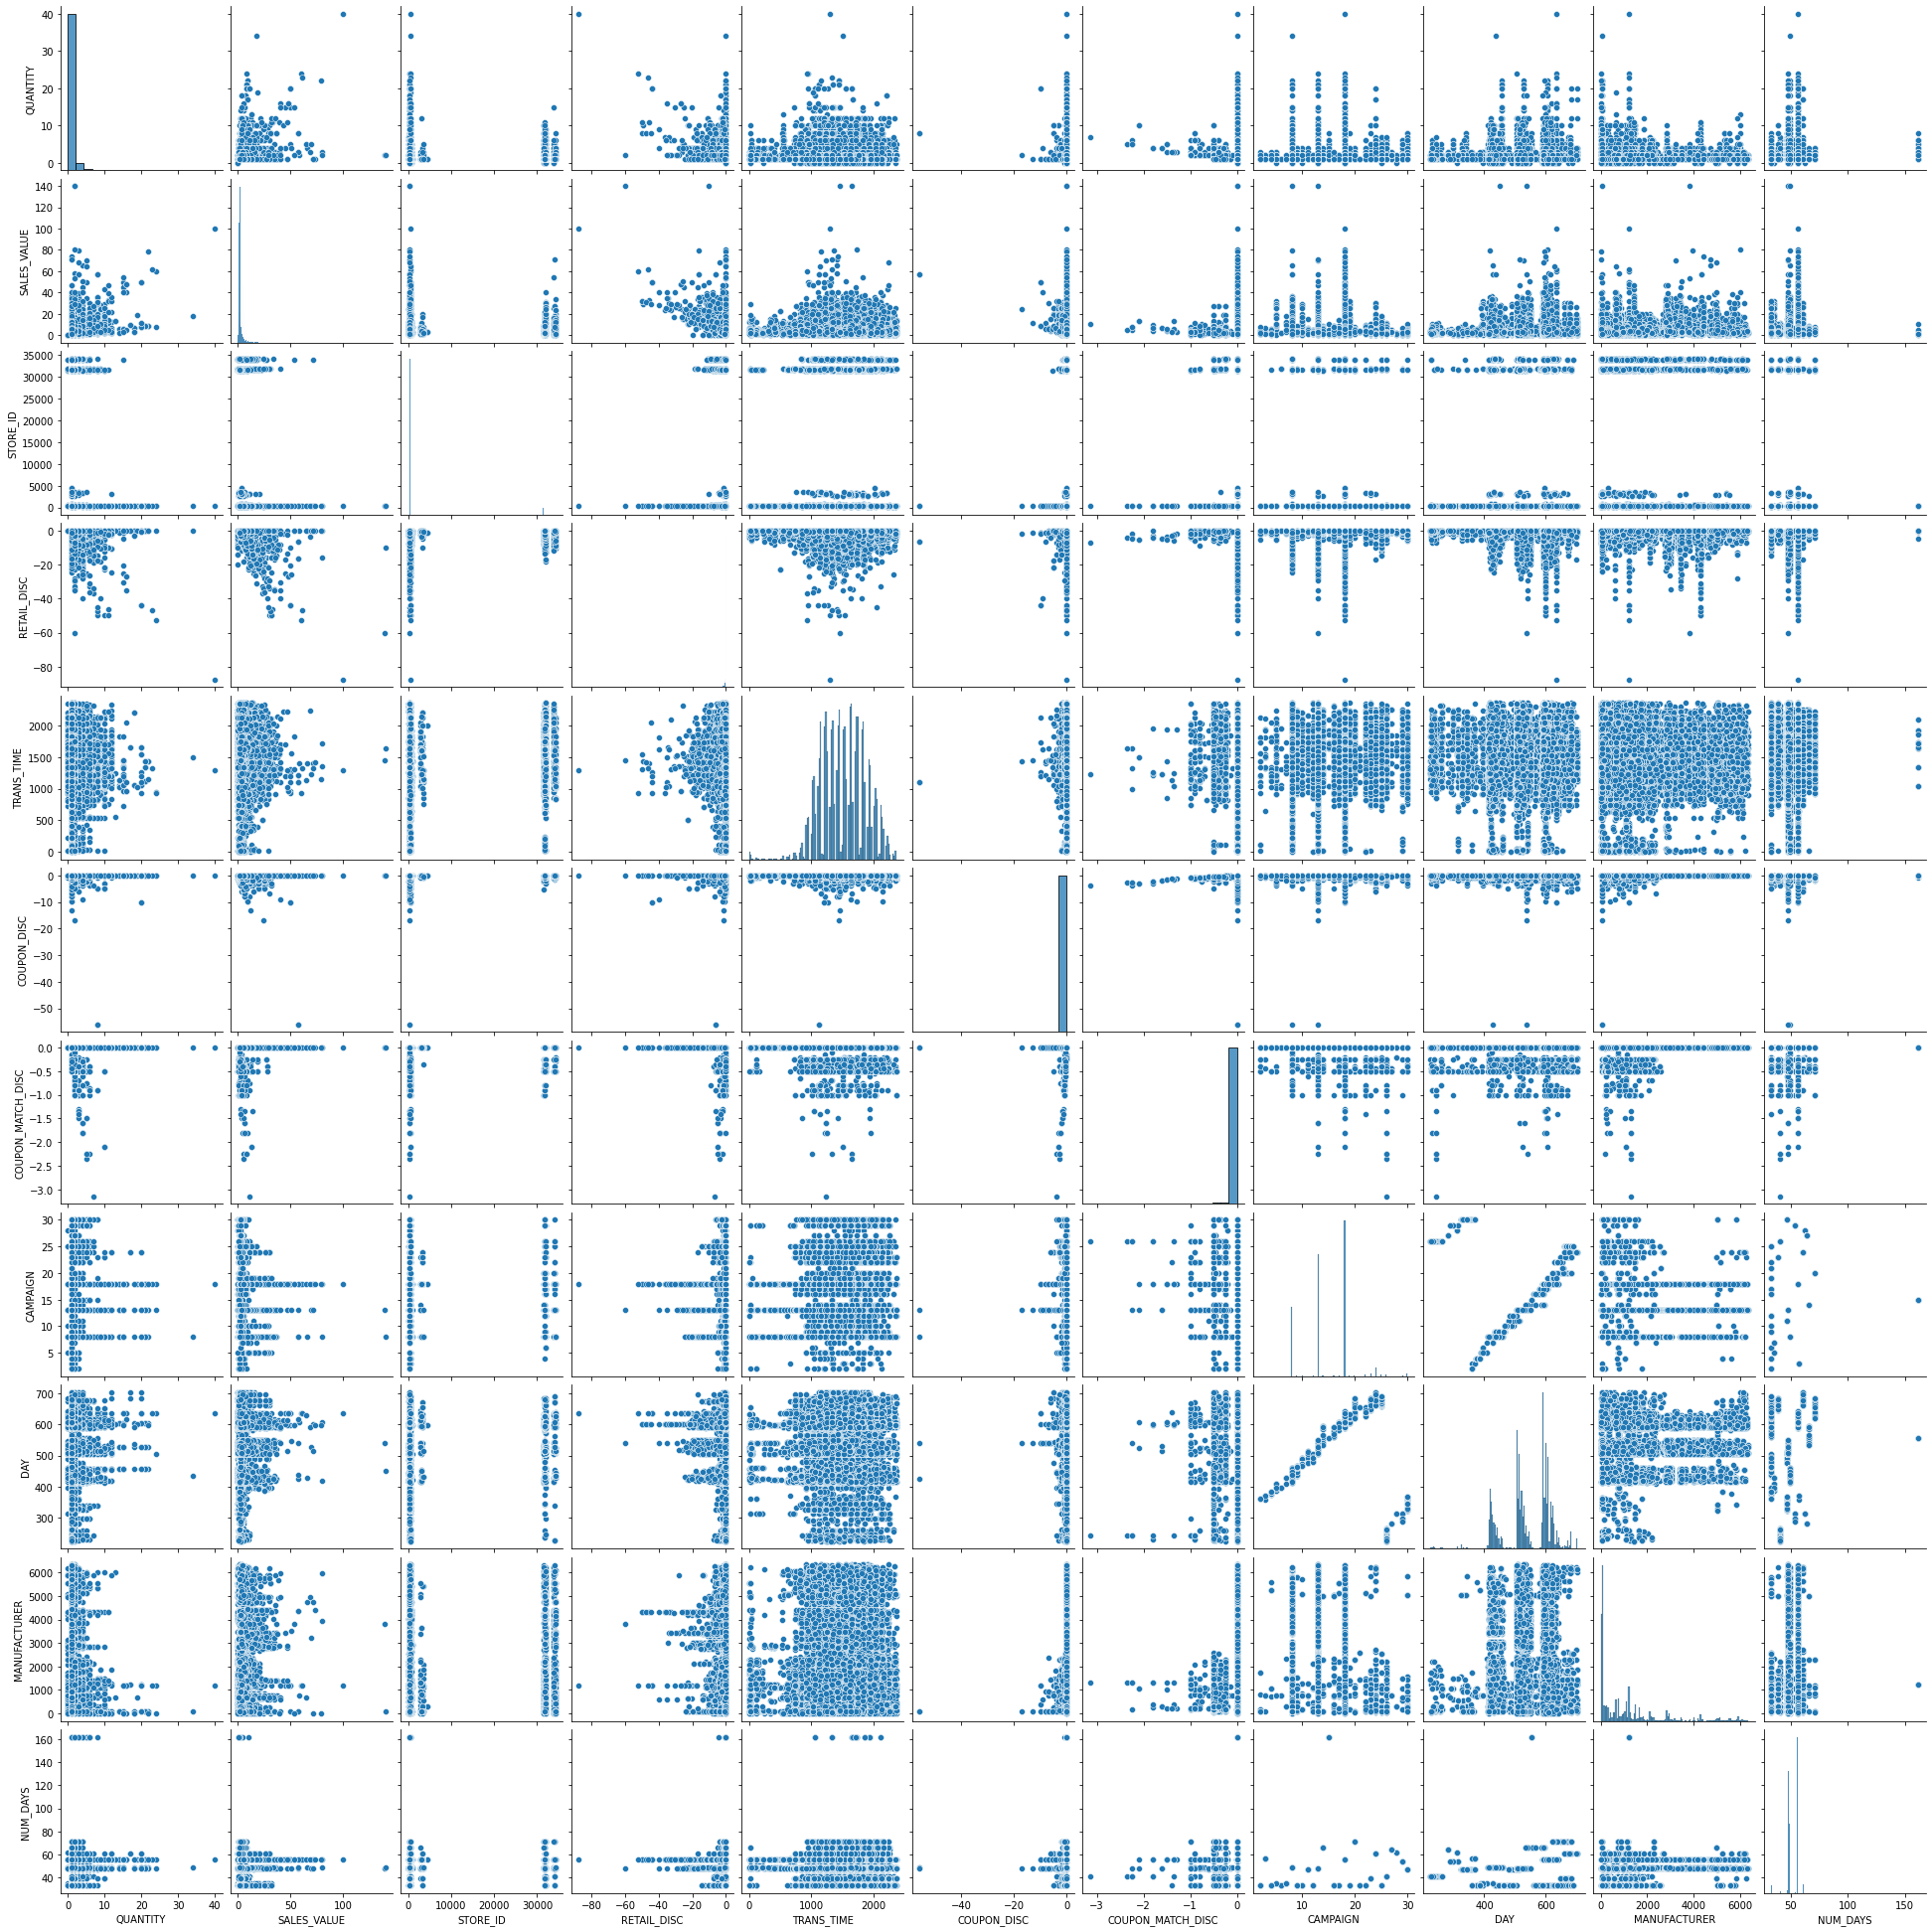

In [42]:
sns.pairplot(df_data)

In [43]:
df_data

,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,COUPON_DISC,COUPON_MATCH_DISC,description,CAMPAIGN,DAY,...,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,NUM_DAYS
0,1,1.67,414,-1.02,1300,0.0,0.0,TypeA,13,510,...,Single Female,1,None/Unknown,69,GROCERY,Private,CHEESE,SHREDDED CHEESE,8 OZ,48
1,1,1.79,414,-0.90,1220,0.0,0.0,TypeA,13,510,...,Single Female,1,None/Unknown,69,GROCERY,Private,CHEESE,SHREDDED CHEESE,8 OZ,48
2,1,1.89,414,0.00,1111,0.0,0.0,TypeA,13,510,...,Single Female,1,None/Unknown,69,GROCERY,Private,CHEESE,SHREDDED CHEESE,8 OZ,48
3,1,1.67,414,-0.22,1341,0.0,0.0,TypeA,13,510,...,Single Female,1,None/Unknown,69,GROCERY,Private,CHEESE,SHREDDED CHEESE,8 OZ,48
4,1,1.67,414,-0.22,1243,0.0,0.0,TypeA,13,510,...,Single Female,1,None/Unknown,69,GROCERY,Private,CHEESE,SHREDDED CHEESE,8 OZ,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112017,1,2.50,304,-0.19,1456,0.0,0.0,TypeA,18,603,...,1 Adult Kids,4,3+,135,GROCERY,National,FRZN POTATOES,FRZN FRENCH FRIES,26 OZ,56
112018,2,3.70,402,0.00,1334,0.0,0.0,TypeA,8,438,...,2 Adults No Kids,2,None/Unknown,1251,GROCERY,National,SOUP,RTS SOUP: CHUNKY/HOMESTYLE ET,18.8 OZ,49
112019,1,5.49,402,0.00,1334,0.0,0.0,TypeA,18,608,...,2 Adults No Kids,2,None/Unknown,26,DRUG GM,National,DIETARY AID PRODUCTS,DIET CNTRL LIQS NUTRITIONAL,,56
112020,1,5.59,402,0.00,1334,0.0,0.0,TypeA,18,608,...,2 Adults No Kids,2,None/Unknown,26,DRUG GM,National,DIETARY AID PRODUCTS,DIET CNTRL LIQS NUTRITIONAL,,56


Let's compute discount percent and then drop all rows with NA.

In [44]:
df_data['DISCOUNT_PCT']=(df_data['RETAIL_DISC']+df_data['COUPON_DISC']+df_data['COUPON_MATCH_DISC'])*100/(df_data['RETAIL_DISC']+df_data['COUPON_DISC']+df_data['COUPON_MATCH_DISC']+df_data['SALES_VALUE'])
df_data['DISCOUNT_PCT']=~df_data['DISCOUNT_PCT'].isna()
df_data['DISCOUNT_PCT'].isna().sum()

0

In [45]:
df_data['description'].value_counts()   #number of transactions belonging to campaign within each type of campaign.

TypeA    105537
TypeB      5972
TypeC       513
Name: description, dtype: int64

Let's take a look at the most frequent sub-commodities in the dataset.

In [46]:
df_data['SUB_COMMODITY_DESC'].value_counts().head(10)

YOGURT NOT MULTI-PACKS            4618
FLUID MILK WHITE ONLY             4314
BANANAS                           3274
FRZN SS PREMIUM ENTREES/DNRS/N    2309
DAIRY CASE 100% PURE JUICE - O    2063
PREMIUM                           1897
PRIMAL                            1636
SHREDDED CHEESE                   1352
REFRIGERATED COFFEE CREAMERS      1305
FRZN BAGGED VEGETABLES - PLAIN    1284
Name: SUB_COMMODITY_DESC, dtype: int64

In [47]:
df_data[df_data['SUB_COMMODITY_DESC'].str.contains('MILK')]['SUB_COMMODITY_DESC'].unique()

array(['FLUID MILK WHITE ONLY', 'INFANT FORMULA MILK BASE', 'BUTTERMILK',
       'CHOCOLATE MILK', 'MISCELLANEOUS MILK', 'FLUID MILK',
       'SOY/RICE MILK'], dtype=object)

In [48]:
df_data=df_data[(df_data['SUB_COMMODITY_DESC']=='FLUID MILK WHITE ONLY') | (df_data['SUB_COMMODITY_DESC']=='MISCELLANEOUS MILK') | (df_data['SUB_COMMODITY_DESC']=='CHOCOLATE MILK')]

In [49]:
df_data.columns.values

array(['QUANTITY', 'SALES_VALUE', 'STORE_ID', 'RETAIL_DISC', 'TRANS_TIME',
       'COUPON_DISC', 'COUPON_MATCH_DISC', 'description', 'CAMPAIGN',
       'DAY', 'AGE_DESC', 'MARITAL_STATUS_CODE', 'INCOME_DESC',
       'HOMEOWNER_DESC', 'HH_COMP_DESC', 'HOUSEHOLD_SIZE_DESC',
       'KID_CATEGORY_DESC', 'MANUFACTURER', 'DEPARTMENT', 'BRAND',
       'COMMODITY_DESC', 'SUB_COMMODITY_DESC', 'CURR_SIZE_OF_PRODUCT',
       'NUM_DAYS', 'DISCOUNT_PCT'], dtype=object)

In [50]:
df_data.drop(['TRANS_TIME','AGE_DESC', 'MARITAL_STATUS_CODE', 'INCOME_DESC', 'HOMEOWNER_DESC', 'HH_COMP_DESC', 'HOUSEHOLD_SIZE_DESC','KID_CATEGORY_DESC', 'DEPARTMENT', 'COMMODITY_DESC','DISCOUNT_PCT'], axis=1, inplace=True)

/home/user-1711/venv/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [51]:
df_data

,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,COUPON_DISC,COUPON_MATCH_DISC,description,CAMPAIGN,DAY,MANUFACTURER,BRAND,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,NUM_DAYS
72,1,2.49,414,0.00,0.0,0.0,TypeA,13,510,69,Private,FLUID MILK WHITE ONLY,1 GA,48
73,1,2.49,414,0.00,0.0,0.0,TypeA,13,510,69,Private,FLUID MILK WHITE ONLY,1 GA,48
74,1,2.49,414,0.00,0.0,0.0,TypeA,13,510,69,Private,FLUID MILK WHITE ONLY,1 GA,48
75,1,2.49,414,0.00,0.0,0.0,TypeA,13,510,69,Private,FLUID MILK WHITE ONLY,1 GA,48
76,1,1.67,414,-0.82,0.0,0.0,TypeA,13,510,69,Private,FLUID MILK WHITE ONLY,1 GA,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111432,1,1.00,292,-0.49,0.0,0.0,TypeA,18,608,531,National,CHOCOLATE MILK,PT,56
111433,1,2.89,292,0.00,0.0,0.0,TypeA,18,608,69,Private,CHOCOLATE MILK,1 GA,56
111435,1,1.00,292,-0.49,0.0,0.0,TypeA,18,608,531,National,MISCELLANEOUS MILK,13.5 OZ,56
111895,1,2.00,368,0.00,0.0,0.0,TypeA,13,506,5423,National,FLUID MILK WHITE ONLY,,48


In [52]:
df_data['CURR_SIZE_OF_PRODUCT'].value_counts()

1 GA        2280
            2053
16 OZ         98
1 QT          90
1 PT          63
1/2 GAL       51
64 OZ         40
32 OZ         19
GAL           17
8 OZ          12
1 GAL         10
PT             8
.5 GAL         6
13.5 OZ        5
6PK/8 OZ       1
QT             1
1/2GAL         1
Name: CURR_SIZE_OF_PRODUCT, dtype: int64

In [53]:
def label_to_volume(label):
    volume=int()
    if label=='1 GA':
        volume=128
    elif label=='1 PT':
        volume=16
    elif label=='16 OZ':
        volume=16
    elif label=='1 QT':
        volume=32
    elif label=='PT':
        volume=16
        
    return volume

vect_label_to_volume=np.vectorize(label_to_volume)

In [54]:
df_data['VOLUME']=vect_label_to_volume(df_data['CURR_SIZE_OF_PRODUCT'])
df_data.head()

<ipython-input-54-8553da09263f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['VOLUME']=vect_label_to_volume(df_data['CURR_SIZE_OF_PRODUCT'])


,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,COUPON_DISC,COUPON_MATCH_DISC,description,CAMPAIGN,DAY,MANUFACTURER,BRAND,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,NUM_DAYS,VOLUME
72,1,2.49,414,0.00,0.0,0.0,TypeA,13,510,69,Private,FLUID MILK WHITE ONLY,1 GA,48,128
73,1,2.49,414,0.00,0.0,0.0,TypeA,13,510,69,Private,FLUID MILK WHITE ONLY,1 GA,48,128
74,1,2.49,414,0.00,0.0,0.0,TypeA,13,510,69,Private,FLUID MILK WHITE ONLY,1 GA,48,128
75,1,2.49,414,0.00,0.0,0.0,TypeA,13,510,69,Private,FLUID MILK WHITE ONLY,1 GA,48,128
76,1,1.67,414,-0.82,0.0,0.0,TypeA,13,510,69,Private,FLUID MILK WHITE ONLY,1 GA,48,128


In [55]:
df_data.groupby('CAMPAIGN').sum()

,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,COUPON_DISC,COUPON_MATCH_DISC,DAY,MANUFACTURER,NUM_DAYS,VOLUME
CAMPAIGN,,,,,,,,,,
8,4414,7395.21,11526800,-2260.05,-6.09,-1.40,1038395,253625,119119,165888
13,2651,4388.69,5413378,-1344.57,-7.52,-0.45,839104,235690,78096,88576
18,1474,2299.86,917666,-798.35,-4.54,-1.45,419973,71762,39032,42960


In [56]:
df_data=df_data[df_data['SALES_VALUE']<=8]

In [57]:
sales=df_data['SALES_VALUE']

In [58]:
df_data_features=df_data.drop('SALES_VALUE', axis=1)

In [59]:
dummy=pd.get_dummies(df_data_features['BRAND'],drop_first=True)
dummy_milk_type=pd.get_dummies(df_data_features['SUB_COMMODITY_DESC'],drop_first=True)
#dummy_hh_size_desc=pd.get_dummies(df_s_parent_features['HOUSEHOLD_SIZE_DESC'],drop_first=True)
dummy_manufacturer=pd.get_dummies(df_data_features['MANUFACTURER'],drop_first=True)
df_data_features=pd.concat([df_data_features,dummy], axis=1)
df_data_features=pd.concat([df_data_features,dummy_milk_type], axis=1)
#df_s_parent_features=pd.concat([df_s_parent_features,dummy_hh_size_desc], axis=1)
df_data_features=pd.concat([df_data_features,dummy_manufacturer], axis=1)
df_data_features.columns

Index([             'QUANTITY',              'STORE_ID',
                 'RETAIL_DISC',           'COUPON_DISC',
           'COUPON_MATCH_DISC',           'description',
                    'CAMPAIGN',                   'DAY',
                'MANUFACTURER',                 'BRAND',
          'SUB_COMMODITY_DESC',  'CURR_SIZE_OF_PRODUCT',
                    'NUM_DAYS',                'VOLUME',
                     'Private', 'FLUID MILK WHITE ONLY',
          'MISCELLANEOUS MILK',                     531,
                           709,                     865,
                           926,                     927,
                          1078,                    1453,
                          1487,                    1543,
                          5423],
      dtype='object')

In [60]:
df_data_features.drop(['STORE_ID','QUANTITY','BRAND','description','MANUFACTURER','CURR_SIZE_OF_PRODUCT','SUB_COMMODITY_DESC', 'CAMPAIGN', 'NUM_DAYS'], axis=1, inplace=True)

<AxesSubplot:>

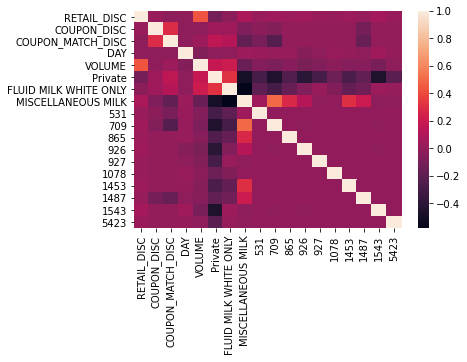

In [61]:
sns.heatmap(df_data_features.corr())

In [62]:
df_data_features.columns.values

array(['RETAIL_DISC', 'COUPON_DISC', 'COUPON_MATCH_DISC', 'DAY', 'VOLUME',
       'Private', 'FLUID MILK WHITE ONLY', 'MISCELLANEOUS MILK', 531, 709,
       865, 926, 927, 1078, 1453, 1487, 1543, 5423], dtype=object)

In [63]:
X=df_data_features
y=sales

In [64]:
X_train,X_test,y_train,y_test=train_test_split(X, y, random_state = 22)

Instantiate StandardScaler and save scaling data.

In [65]:
sscaler=StandardScaler()

In [66]:
X_train_scaled=sscaler.fit_transform(X_train)
dump(sscaler,'./models/scaler_file.save')

X_test_scaled=sscaler.fit_transform(X_test)

In [67]:
lasso=Lasso(alpha=0.00001,max_iter=99999)
lasso.fit(X_train_scaled,y_train)

Lasso(alpha=1e-05, max_iter=99999)

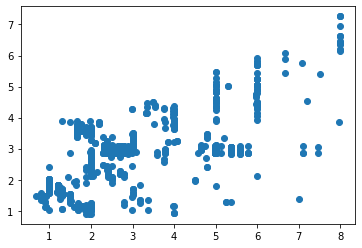

In [68]:
y_preds=lasso.predict(X_test_scaled)
plt.scatter(y_test,y_preds)

/home/user-1711/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='SALES_VALUE'>

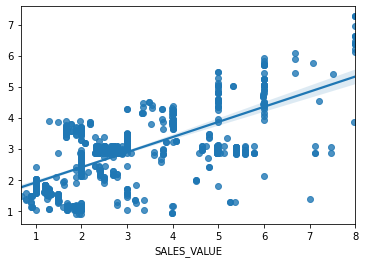

In [69]:
sns.regplot(y_test,y_preds)

In [70]:
features_and_coefs=pd.DataFrame({'features':X.columns, 'coefs':lasso.coef_}).sort_values(by='coefs', ascending=False)
features_and_coefs #.features.values

,features,coefs
4,VOLUME,0.896657
16,1543,0.261528
7,MISCELLANEOUS MILK,0.167366
11,926,0.155791
12,927,0.125047
13,1078,0.085092
3,DAY,0.075319
17,5423,0.046313
6,FLUID MILK WHITE ONLY,0.039078
15,1487,0.027433


In [71]:
X_test_scaled[0]

array([-0.00927262,  0.05802566,  0.05726216, -0.93306465,  1.02181264,
        0.20080483,  0.31532811, -0.1839509 , -0.06576671, -0.07788362,
       -0.04154065, -0.09320996, -0.04154065,  0.        , -0.04154065,
       -0.04154065, -0.10219523, -0.05089866])

In [72]:
cross_val_score(lasso, X_train_scaled,y_train)

array([0.48335912, 0.49968012, 0.47314504, 0.51290511, 0.45122714])

In [73]:
cross_val_score(lasso, X_test_scaled,y_test)

array([0.54052384, 0.52403228, 0.55475358, 0.44124059, 0.3566875 ])

Next let's take the columns whose coefficients have a magnitude over 0.01. We'll try to estimate using ridge instead of lasso and see hot it performs.

NB: REMOVE THE UNECESSARY COLUMNS FROM THE FEATURE MATRIX. NOT DONE YET.

In [74]:
ridge=Ridge()
ridge.fit(X_train_scaled,y_train)

Ridge()

In [75]:
y_ridge_preds=ridge.predict(X_test_scaled)

In [76]:
cross_val_score(ridge, X_test_scaled,y_test)

array([0.55928865, 0.52393542, 0.55468027, 0.44162744, 0.35685181])

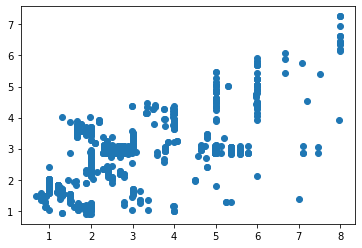

In [77]:
plt.scatter(y_test,y_ridge_preds)

save both models

In [78]:
dump(lasso, './models/sales_value_lasso_model.joblib')

['./models/sales_value_lasso_model.joblib']

In [79]:
dump(ridge, './models/sales_value_ridge_model.joblib')

['./models/sales_value_ridge_model.joblib']